## PyTorch Image classification on `Custom dataset`

### import libraries

In [1]:
import numpy as np
import torch
import torchvision
from torchvision.transforms import v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Get the dataset 🙀

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
        )
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


### visualize data

In [3]:
import os


def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
      dir_path (str or pathlib.Path): target directory

    Returns:
      A print out of:
        number of sub-directories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'."
        )

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

random_image_path=PosixPath('data/pizza_steak_sushi/train/sushi/1129338.jpg')


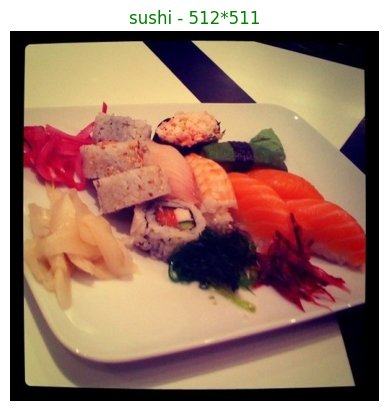

random_image_path=PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg')


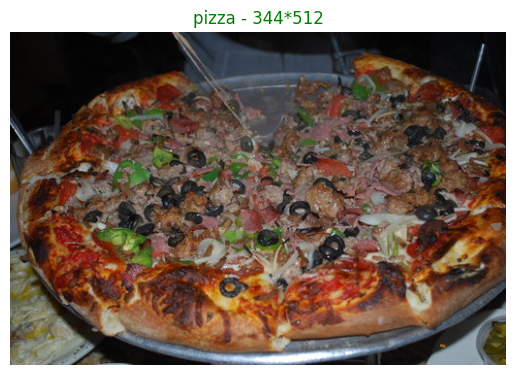

random_image_path=PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg')


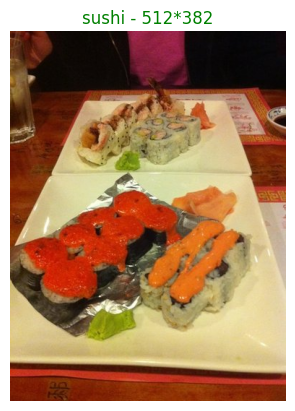

random_image_path=PosixPath('data/pizza_steak_sushi/train/steak/2614189.jpg')


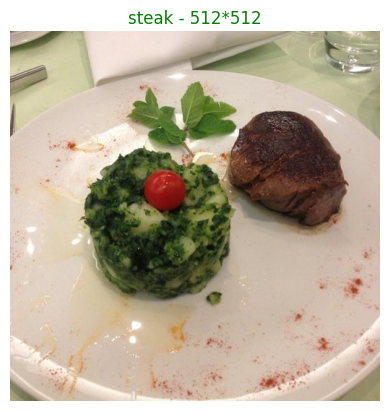

random_image_path=PosixPath('data/pizza_steak_sushi/train/steak/2628106.jpg')


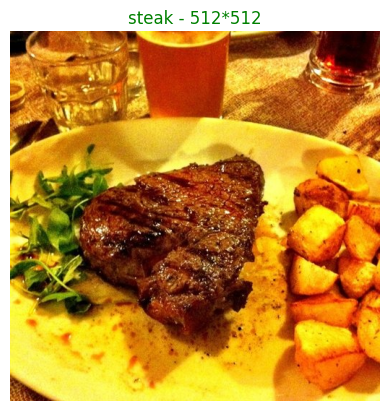

In [6]:
import random
from PIL import Image
from torchvision.io import read_image
import matplotlib.pyplot as plt

for i in range(5):
    # Set seed
    random.seed(i)  # <- try changing this and see what happens

    # 1. Get all image paths (* means "any combination")
    image_path_list = list(image_path.glob("*/*/*.jpg"))

    # 2. Get random image path
    random_image_path = random.choice(image_path_list)

    # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
    image_class = random_image_path.parent.stem
    print(f"{random_image_path=}")

    # 4. Open image
    img = read_image(str(random_image_path))
    
    plt.imshow(img.permute(1,2,0))
    plt.title(f"{image_class} - {img.shape[1]}*{img.shape[2]}", color="green")
    plt.axis('off')
    plt.show()

### Transform dataset 🎭

In [7]:
from torchvision.transforms import v2

# Write transform for image
data_transform = v2.Compose(
    [
        v2.PILToTensor(),
        v2.AutoAugment(),
        # Resize the images to 64x64
        v2.Resize(size=(64, 64), antialias=True),
        # Flip the images randomly on the horizontal
        v2.RandomHorizontalFlip(p=0.5),  # p = probability of flip, 0.5 = 50% chance
        # Turn the image into a torch.Tensor
        v2.ToDtype(
            torch.float32, scale=True
        ),  # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ]
)

### let's visualize the transformations

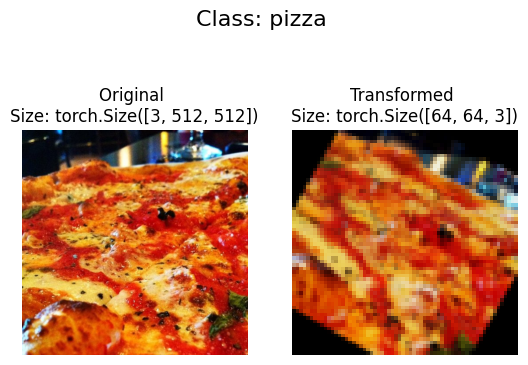

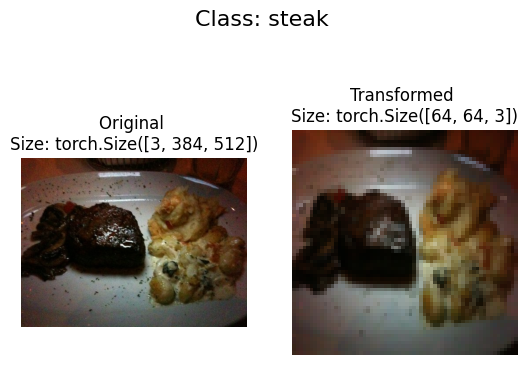

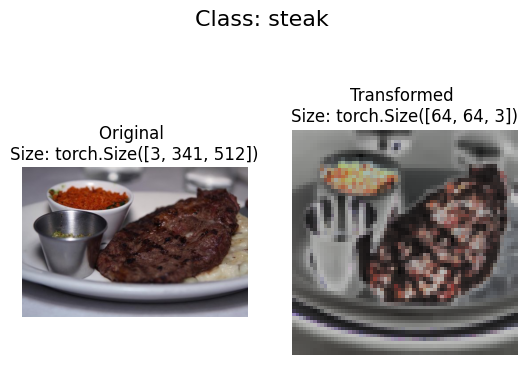

In [8]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        img = read_image(str(image_path))
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img.permute(1, 2, 0))
        ax[0].set_title(f"Original \nSize: {img.shape}")
        ax[0].axis("off")

        # Transform and plot image
        # Note: permute() will change shape of image to suit matplotlib
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = transform(img).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_path_list, transform=data_transform, n=3)

## Now, we need to load Dataset that we can use for training.

- We can either use `ImageFolder` or create our own `Dataset`.

### Option 1: Using `ImageFolder`

In [9]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,  # target folder of images
    transform=data_transform,  # transforms to perform on data (images)
    target_transform=None,
)  # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

# Get class names as a list
class_names = train_data.classes
print(f"{class_names=}")

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print(f"{class_dict=}")

# Check the lengths
print(f"{len(train_data)=}, {len(test_data)=}")

class_names=['pizza', 'steak', 'sushi']
class_dict={'pizza': 0, 'steak': 1, 'sushi': 2}
len(train_data)=225, len(test_data)=75


In [10]:
img, label = train_data[0][0], train_data[0][1]
print(f"{img=}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

img=tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0941, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0706],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1412, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1020, 0.1020]],

        [[0.0235, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0157, 0.0157, 0.0196,  ..., 0.0902, 0.0902, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0902, 0.0902

### Turn dataset into `Dataloaders`

- Turning our Dataset's into DataLoader's makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

In [11]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,  # how many samples per batch?
    num_workers=1,  # how many subprocesses to use for data loading? (higher = more)
    shuffle=True,
)  # shuffle the data?

test_dataloader = DataLoader(
    dataset=test_data, batch_size=1, num_workers=1, shuffle=False
)  # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1271703d0>,
 <torch.utils.data.dataloader.DataLoader at 0x127170130>)

In [12]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


---

### Option 2: Loading Image Data with a `Custom Dataset`

[https://www.learnpytorch.io/04_pytorch_custom_datasets/#5-option-2-loading-image-data-with-a-custom-dataset](https://www.learnpytorch.io/04_pytorch_custom_datasets/#5-option-2-loading-image-data-with-a-custom-dataset)

---

### Start creating CNN model 😎

In [13]:
import torch.nn as nn

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,  # how big is the square that's going over the image?
                stride=1,  # default
                padding=1,
            ),  # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units * 16 * 16, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion


torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3,  # number of color channels (3 for RGB)
    hidden_units=10,
    output_shape=len(train_data.classes),
).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### Train model

In [14]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [15]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [16]:
from tqdm.auto import tqdm


# 1. Take in various parameters required for training and test steps
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
):
    # 2. Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn
        )

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [17]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Recreate an instance of TinyVGG
model_0 = TinyVGG(
    input_shape=3,  # number of color channels (3 for RGB)
    hidden_units=10,
    output_shape=len(train_data.classes),
).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Train model_0
model_0_results = train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1186 | train_acc: 0.2933 | test_loss: 1.0967 | test_acc: 0.4133
Epoch: 2 | train_loss: 1.1016 | train_acc: 0.3067 | test_loss: 1.0995 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0992 | train_acc: 0.2889 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3289 | test_loss: 1.1000 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.1043 | train_acc: 0.3467 | test_loss: 1.0997 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0991 | train_acc: 0.3467 | test_loss: 1.1005 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0985 | train_acc: 0.3467 | test_loss: 1.1001 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0976 | train_acc: 0.3778 | test_loss: 1.0735 | test_acc: 0.4800
Epoch: 9 | train_loss: 1.1030 | train_acc: 0.3511 | test_loss: 1.1026 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1026 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1029 | test_acc: 0.3333
Epoch: 12 | train_l

### Plot loss Curve

In [18]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

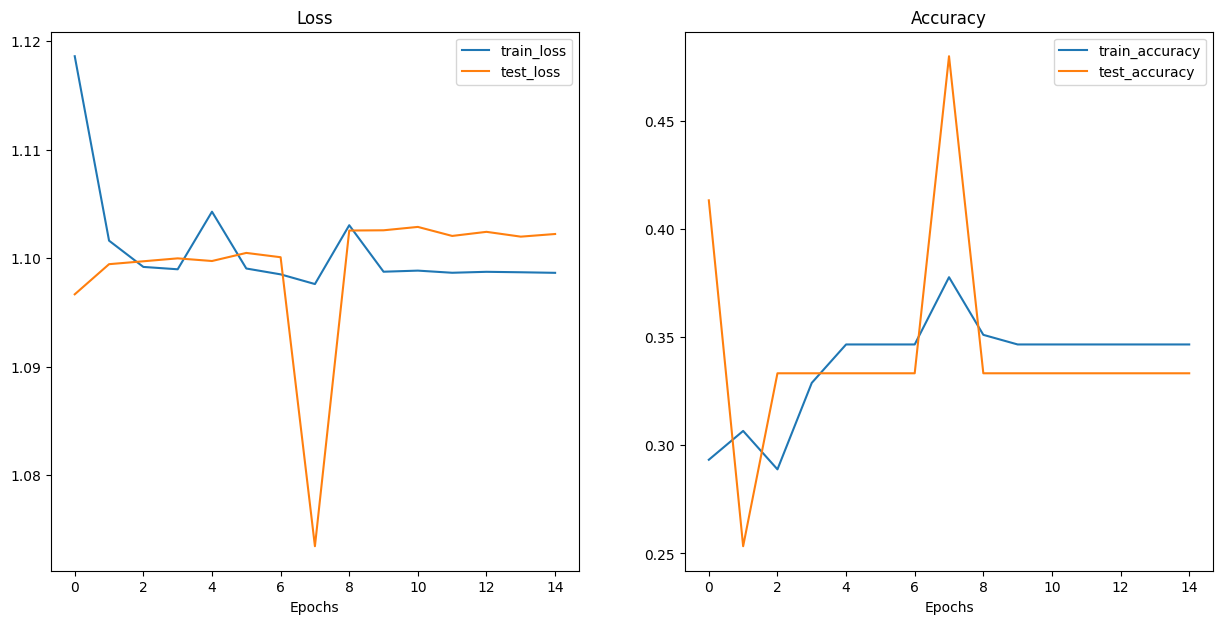

In [19]:
plot_loss_curves(model_0_results)

## Accuracy ✅❌

In [20]:
# Set the model to evaluation mode, disabling dropout and using population
# statistics for batch normalization.
model_0.eval()

# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    correct_pred = 0
    incorrect_pred = 0
    for i, v_data in enumerate(test_dataloader):
        v_inputs, v_labels = v_data
        # load inputs & labels on device
        v_inputs = v_inputs.to(device=device)
        v_labels = v_labels.to(device=device)

        v_outputs = model_0(v_inputs)
        # we're sending 4 images in a batch at once as input to the model.
        # hence, we will get output (4*10 predictions).
        # we need to apply argmax on axis=1, to get prediction for each image.
        predicted_output = v_outputs.argmax(dim=1)

        correct_pred += (predicted_output == v_labels).sum()
        incorrect_pred += (predicted_output != v_labels).sum()

    accuracy = correct_pred / len(test_dataloader)
    print(f"accuracy on validation dataset is: {accuracy}")
    print(f"{correct_pred=}; {incorrect_pred=}")

accuracy on validation dataset is: 0.3333333432674408
correct_pred=tensor(25); incorrect_pred=tensor(50)


---

### Visualize predictions on test-dataset

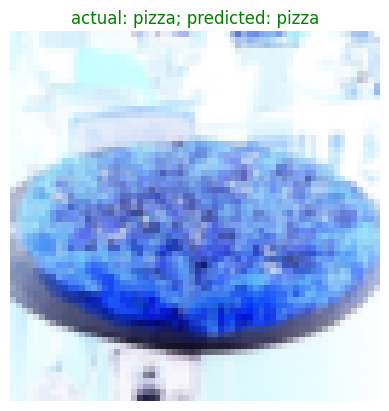

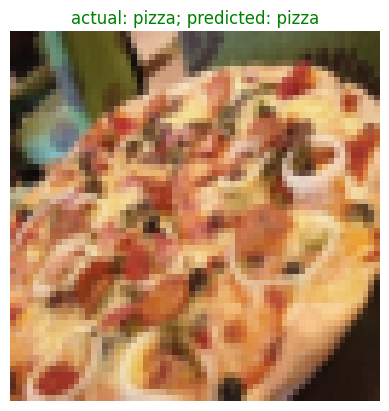

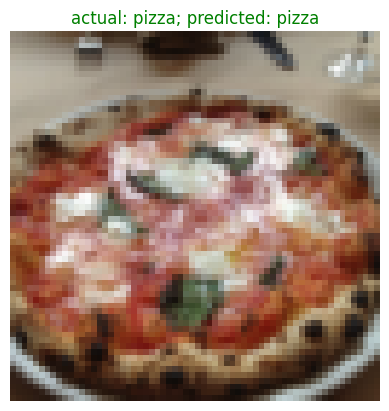

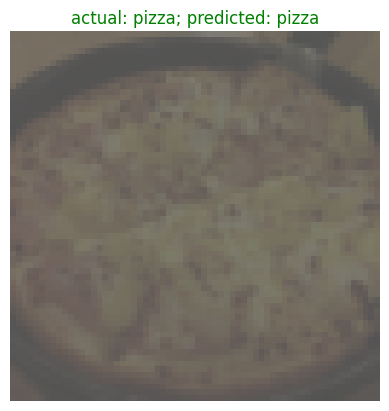

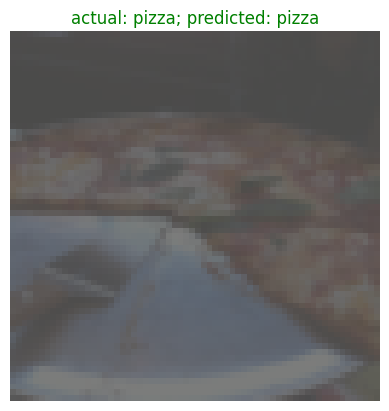

In [21]:
for idx, new_test_dataset in enumerate(test_dataloader):
    if idx==5:
        break
    img, label = new_test_dataset

    # load img & label in device
    img = img.to(device)
    label = label.to(device)

    predicted_label = model_0(img)
    predicted_label_output = predicted_label.argmax(dim=1)

    plt.imshow(img[0].permute(1, 2, 0))

    color = "red"
    if label[0] == predicted_label_output[0]:
        color = "green"
    plt.title(
        f"actual: {class_names[label[0]]}; predicted: {class_names[predicted_label_output]}",
        color=color,
    )
    plt.axis("off")
    plt.show()